# Results for TSMCN-8-L-229 with analytics
RSAT=0.01 and 90 spectra per class

In [1]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
import numpy as np
from numpy import asarray
import pandas as pd
import math
import seaborn as sns  #heat map
import glob # batch processing of images


import matplotlib.font_manager as fm
import random
import sys
import os

from sklearn.datasets import make_regression
# import tensorflow as tf
from sklearn.metrics import confusion_matrix    #confusion matrix
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# Collect all the font names available to matplotlib
font_names = [f.name for f in fm.fontManager.ttflist]
# print(font_names)

from scipy import signal
from scipy import interpolate

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF

#Sklearn model saving and loading
from joblib import dump, load

if '../../' not in sys.path:
    sys.path.append('../../')

from aimos.spectral_datasets.THz_datasets import THz_data

from aimos.misc.utils import simple_plotter


#Set random seed
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
# tf.random.set_seed(42)  
# tf.random.get_global_generator().reset_from_seed(42)
np.random.seed(42)
random.seed(42)

from oneida import THz_mixture_data
from oneida_utils import concentrations_to_one_hot_encode, create_mixture_names
from oneida_utils import simple_spectrum_fig, simple_plot_raw_scores, plot_spectrum_with_scores, multiclass_roc_auc_score, multiclass_sensitivity_specificity_score, multiclass_sensitivity_threshold_score
from oneida_scoring_tools import calc_AMCAS, is_cui_present, is_cui_present_in_mult
from aimos.misc.utils import classifier_internals
from aimos.misc.utils import clf_post_processor
from oneida_utils import mixture_names_to_one_hot_encode
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from oneida_grad_cam import grad_cam

from stats import stats
stats(n_compounds=8)

2022-11-14 17:34:29.457397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 17:34:29.567833: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-14 17:34:29.572156: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-11-14 17:34:29.572168: I tensorflow/stream_execu

Total 1-C combinations: 8
Total 2-C combinations: 28
Total 3-C combinations: 56
Total 4-C combinations: 70
Total 5-C combinations: 56
Total 6-C combinations: 28
Total 7-C combinations: 8
Total 8-C combinations: 1
Total combinations: 255


# Retrieve training(D)+ validation(V) mixtures and its variables

In [2]:
# initialize
TAAT = 0.001 
ASAT=0.01
RSAT=0.01

m = THz_mixture_data(resolution=0.016, pressure='1 Torr', verbosity=False)
m.initiate_THz_mixture_data(TAAT = TAAT, 
                               ASAT=ASAT, 
                               RSAT=RSAT)

reduced_labels = m.labels
reduced_labels.remove('')
reduced_labels.remove(' ')
reduced_labels.remove('Diluent')
print('reduced_labels', reduced_labels)


# data_filename = "datasets/TSMCN-5-L-229_DV_04-09-2022_time_22-26-37.pkl"
data_filename = "datasets/TSMCN-8-L-229_DV__TAAT_0.001_ASAT_0.01_RSAT_0.01_20-10-2022_time_23-16-29_class_cnt_90.pkl"
DV = pd.read_pickle(data_filename)
y = DV['y'].to_numpy()
mixture_names = DV['mixture_names'].to_numpy()
y_concentrations = DV[['y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4', 'y_c5', 'y_c6', 'y_c7']].to_numpy()
X = DV.drop(['y','mixture_names', 'y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4', 'y_c5', 'y_c6', 'y_c7'],axis=1).to_numpy()

final_neuron_number = np.unique(y, axis=0).shape[0]
print('Number of neurons in the final layer :', final_neuron_number)

print('labels from class:', m.labels)

Components :  [[0 1 2 3 4 5 6 7 8]]
Components shape :  (1, 9)
TAAT =  0.001
ASAT =  0.01
RSAT =  0.01
reduced_labels ['$C_2H_5OH$', '$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$H_2CO$', '$HCOOH$', '$HNO_3$']
Number of neurons in the final layer : 255
labels from class: ['$C_2H_5OH$', '$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$H_2CO$', '$HCOOH$', '$HNO_3$']


# preview one test mixture spectra using simple plotter

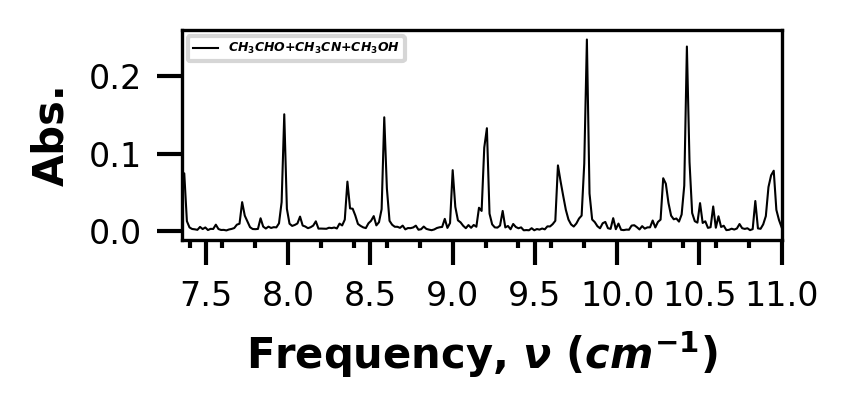

[0.0 0.09513228524765269 0.0 0.0798460102552229 0.08445525958626961 0.0
 0.0 0.0]
['$C_2H_5OH$', '$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$H_2CO$', '$HCOOH$', '$HNO_3$']


In [3]:
idx = 239
simple_plotter(m.frequencies,X[idx],linewidth=0.5,color='black',label=mixture_names[idx], 
                   majorsize=6,minorsize=2,width=1, labelsize=8,legendsize=3, legendloc=2,  
                   labelpad=4,fontsize='medium',fontweight='bold',
                  xmajormplloc=0.5,xminormplloc=0.2, tickdirection='out')

print(y_concentrations[idx])
print(reduced_labels)

In [4]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(mixture_names)

mixture_types=le.classes_
print(mixture_types)

['$CH_3CHO$' '$CH_3CHO$+$CH_3CN$' '$CH_3CHO$+$CH_3CN$+$CH_3OH$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$HCOOH$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$H_2CO$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$H_2CO$+$HCOOH$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$H_2CO$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$H_2CO$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$HCOOH$' '$CH_3CHO$+$CH_3CN$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$HNO_3$' '$CH_3CHO$+$CH_3CN$+$H_2CO$'
 '$CH_3CHO$+$CH_3CN$+$H_2CO$+$HCOOH$'
 '$CH_3CHO$+$CH_3CN$+$H_2CO$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$H_2CO$+$HNO_3$' '$CH_3CHO$+$CH_3Cl$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$' '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$HCOOH$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$HNO_3$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$H_2CO$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$H_2CO$+$HCOOH$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN

In [5]:
reduced_labels

['$C_2H_5OH$',
 '$CH_3CHO$',
 '$CH_3Cl$',
 '$CH_3CN$',
 '$CH_3OH$',
 '$H_2CO$',
 '$HCOOH$',
 '$HNO_3$']

In [6]:
# mixture_types[19]
for lab in reduced_labels:
    print(f'{lab} ------------- {mixture_types.tolist().index(lab)}')

$C_2H_5OH$ ------------- 120
$CH_3CHO$ ------------- 0
$CH_3Cl$ ------------- 80
$CH_3CN$ ------------- 64
$CH_3OH$ ------------- 112
$H_2CO$ ------------- 251
$HCOOH$ ------------- 248
$HNO_3$ ------------- 250


In [7]:
# le.transform(mixture_types)
# 

In [8]:
#split intro train and validation set

#seeds used 123,237, 786
from sklearn.model_selection import train_test_split

global_indices=range(0, X.shape[0])
print(global_indices)

# (np.expand_dims(X,-1)
TRAIN_SIZE=0.60
VAL_SIZE=1-TRAIN_SIZE

x_train, x_val, y_train, y_val, train_indices, val_indices = train_test_split(np.expand_dims(X, axis=-1), y, global_indices, train_size=TRAIN_SIZE,
                                                   test_size=VAL_SIZE,
                                                   random_state=786,
                                                    stratify=y

                                                   )

print('X_train shape:', x_train.shape)
print('y_ohe_train shape:', y_train.shape)

print('X_val shape:', x_val.shape)
print('y_ohe_val shape:', y_val.shape)


print("All:", np.bincount(y) / float(len(y))*100  )
print("Training:", np.bincount(y_train) / float(len(y_train))*100  )
print("Validation:", np.bincount(y_val) / float(len(y_val))*100  )


range(0, 22950)
X_train shape: (13770, 229, 1)
y_ohe_train shape: (13770,)
X_val shape: (9180, 229, 1)
y_ohe_val shape: (9180,)
All: [0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215

In [9]:
from oneida_model import get_callbacks, get_optimizer, compile_and_fit, TSMCN_12_L_229

In [10]:
model_name = data_filename.split('.pkl')[0].split('/')[1]
print(model_name)

TSMCN-8-L-229_DV__TAAT_0.001_ASAT_0.01_RSAT_0.01_20-10-2022_time_23-16-29_class_cnt_90


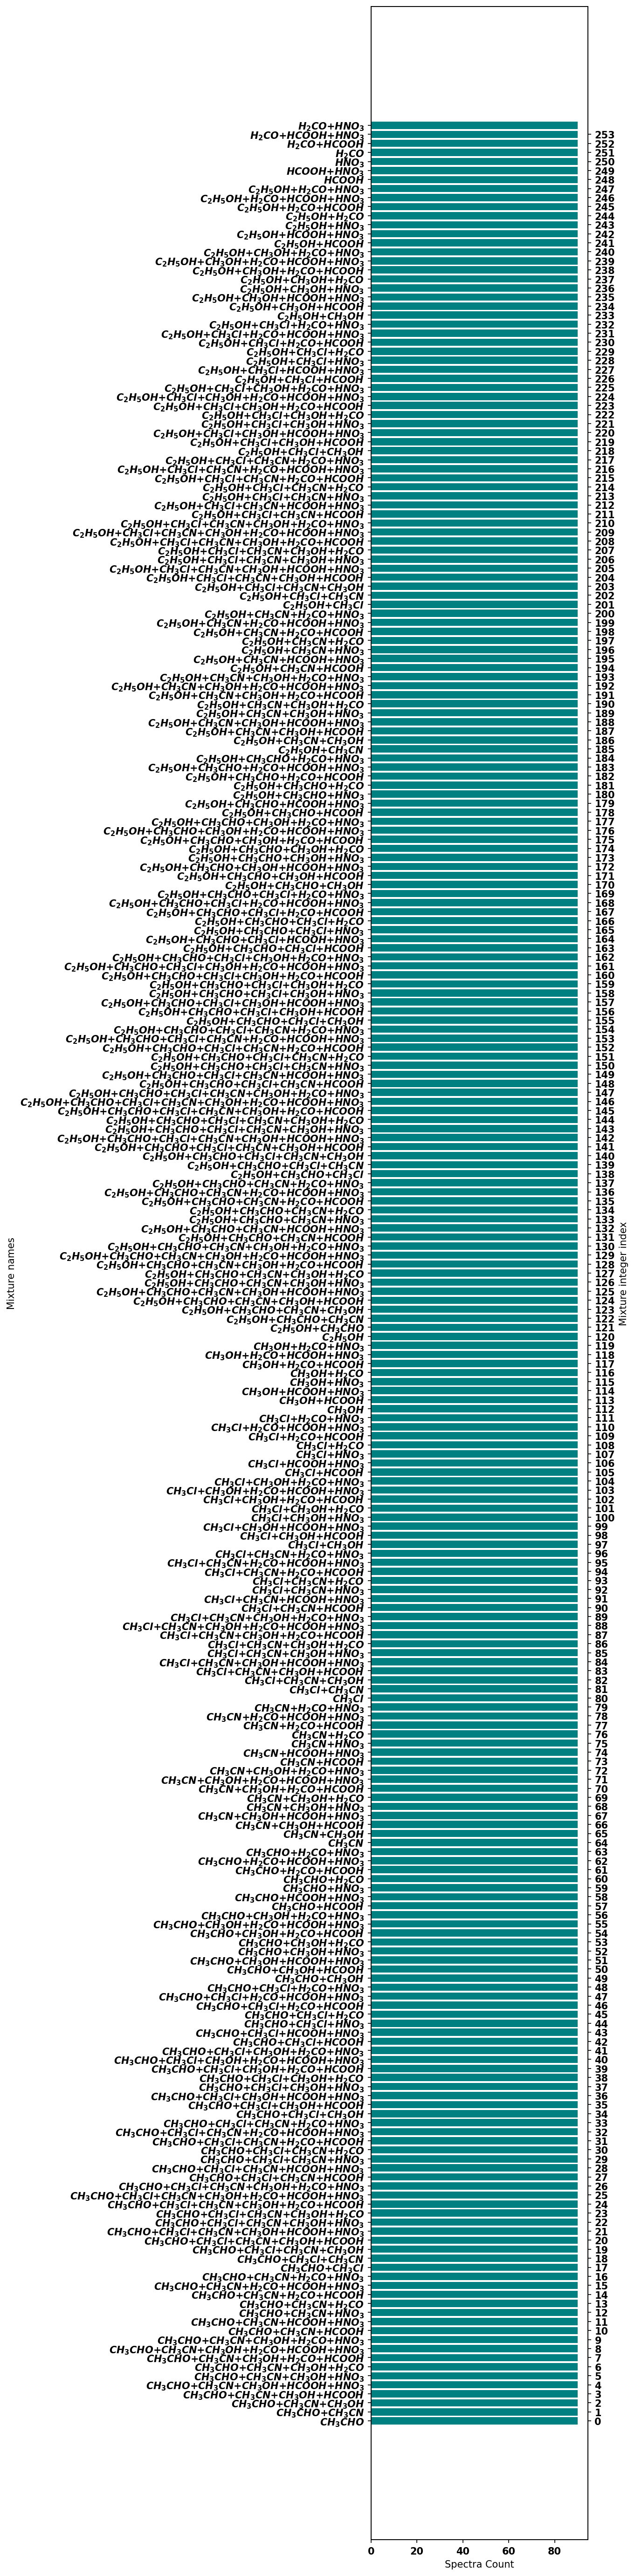

In [11]:
fig, ax1 = plt.subplots(figsize = (4,48),dpi=150)

ax2 = ax1.twinx()
ax1.barh(mixture_types, np.bincount(y), color='teal')
ax2.barh(le.transform(mixture_types), np.bincount(y), color='teal')

ax1.set_xlabel('Spectra Count')
ax1.set_ylabel('Mixture names', color='black')
ax2.set_ylabel('Mixture integer index', color='black')
ax2.yaxis.set_ticks(np.arange(0, np.max(le.transform(mixture_types)), 1))
# plt.tight_layout()
plt.show()
# fig.savefig(r'RESULTS/data_analytics/' + model_name +'_mix_type_dist.png', bbox_inches='tight')

In [12]:


df = pd.DataFrame()
df['Mixture type'] = mixture_types
df['Mixture label index'] = le.transform(mixture_types)
df['Count'] = np.bincount(y)
df.to_excel(r'RESULTS/data_analytics/' + model_name +'_mix_type_dist.xlsx', index=False)

In [13]:
import tensorflow as tf
y_ohe = concentrations_to_one_hot_encode(y_concentrations).astype('int64')
y_train_ohe = y_ohe[train_indices]
y_val_ohe = y_ohe[val_indices]
y_train_ohe_tensor = tf.convert_to_tensor(y_train_ohe, np.int64)
y_val_ohe_tensor = tf.convert_to_tensor(y_val_ohe, np.int64)


2022-11-14 17:35:15.511804: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-11-14 17:35:15.511927: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-11-14 17:35:15.512011: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-11-14 17:35:15.514680: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuso

In [14]:
y_val_named = mixture_types[y_val] # array consisting of string names of validation mixtures

y_train_named = mixture_types[y_train]

# pred_y_named = mixture_types[pred_y] # array consisting of string names of predicted mixtures



1-component mixtures: 432
2-component mixtures: 1512
3-component mixtures: 3024
4-component mixtures: 3780
5-component mixtures: 3024
6-component mixtures: 1512
7-component mixtures: 432
8-component mixtures: 54


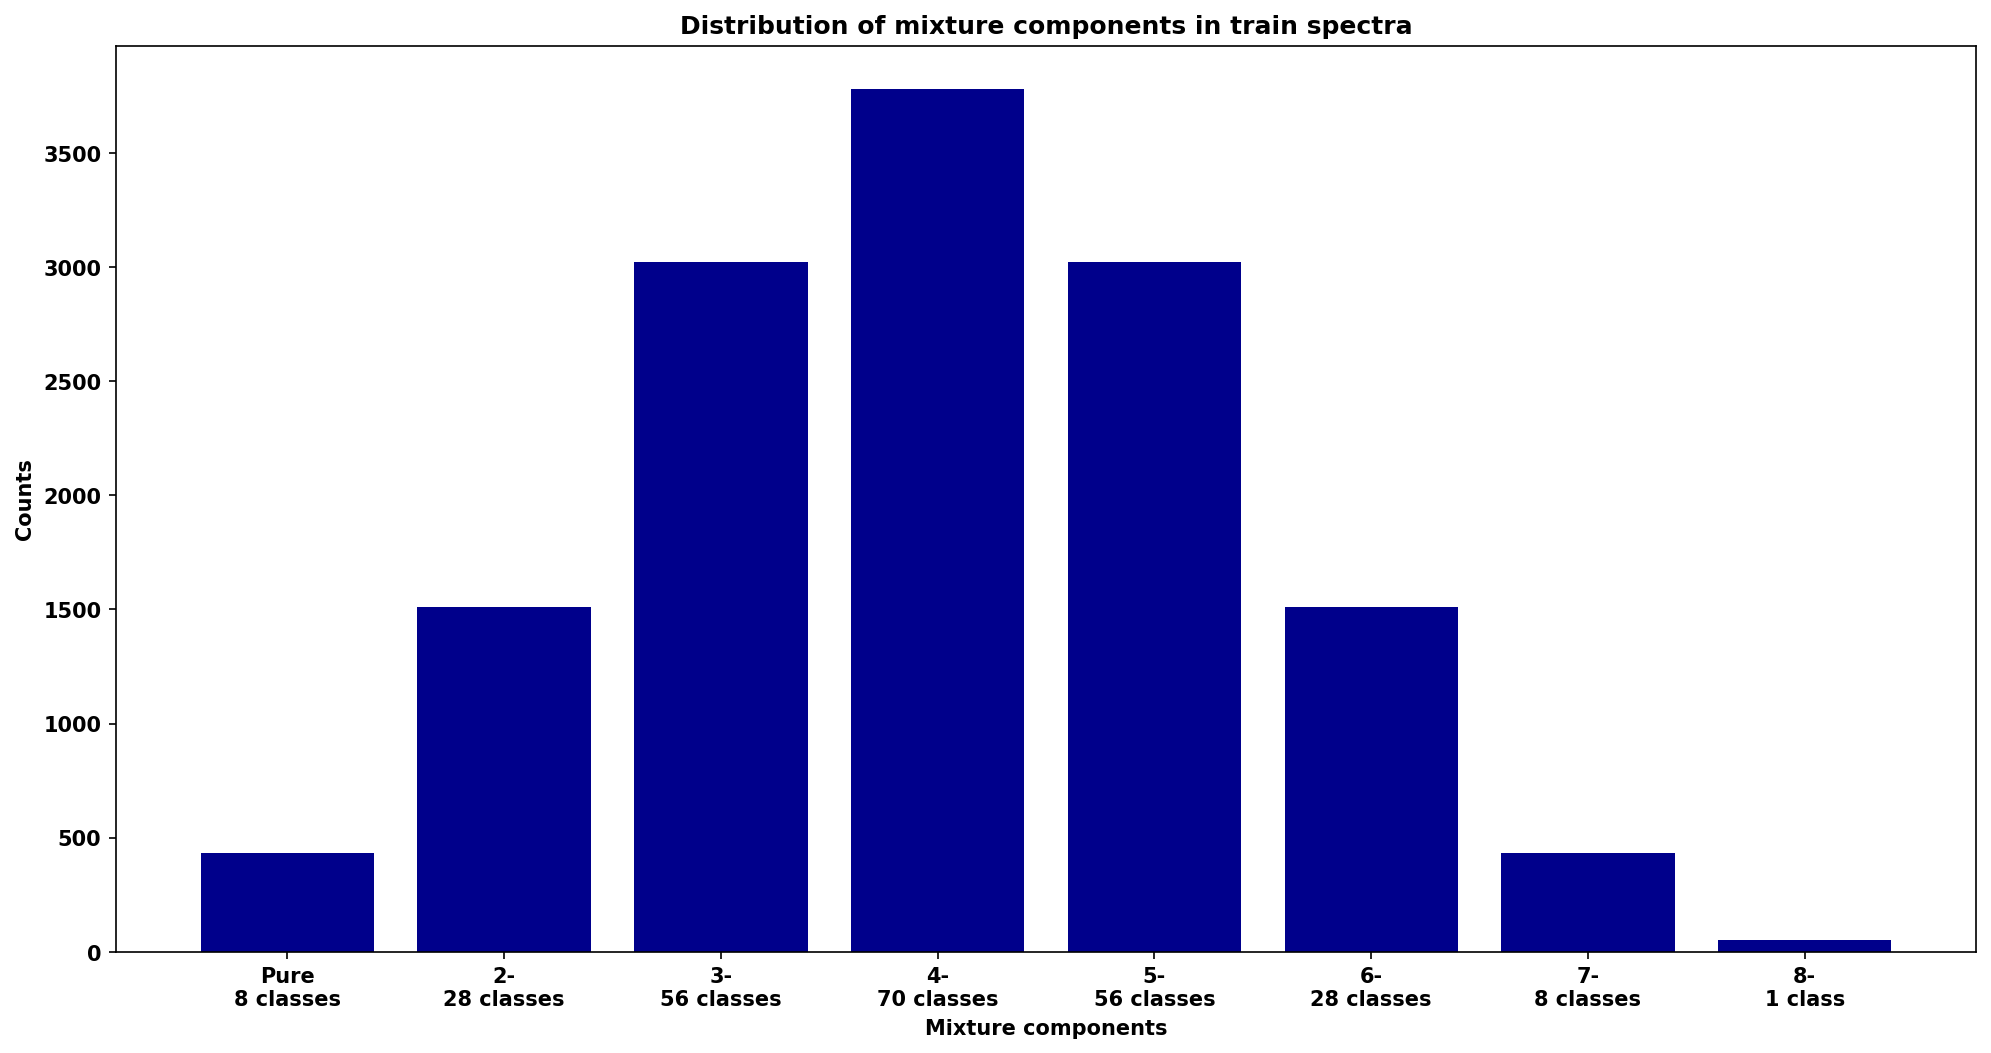

In [15]:
#calculate the distribution of 1,2,3,4,5,6,7,8 mixtures in train spectra

mix_1c = 0
mix_2c = 0
mix_3c = 0
mix_4c = 0
mix_5c = 0
mix_6c = 0
mix_7c = 0
mix_8c = 0

for _ in range(0,y_train_named.shape[0]):
    
        if len(y_train_named[_].split('+', -1)) == 1:
            mix_1c+=1
        elif len(y_train_named[_].split('+', -1)) == 2:
            mix_2c+=1
        elif len(y_train_named[_].split('+', -1)) == 3:
            mix_3c+=1
        elif len(y_train_named[_].split('+', -1)) == 4:
            mix_4c+=1
        elif len(y_train_named[_].split('+', -1)) == 5:
            mix_5c+=1
        elif len(y_train_named[_].split('+', -1)) == 6:
            mix_6c+=1
        elif len(y_train_named[_].split('+', -1)) == 7:
            mix_7c+=1
        elif len(y_train_named[_].split('+', -1)) == 8:
            mix_8c+=1
            
            
            
print('1-component mixtures:', mix_1c)
print('2-component mixtures:', mix_2c)
print('3-component mixtures:', mix_3c)
print('4-component mixtures:', mix_4c)
print('5-component mixtures:', mix_5c)
print('6-component mixtures:', mix_6c)
print('7-component mixtures:', mix_7c)
print('8-component mixtures:', mix_8c)

train_mix_1c =  mix_1c
train_mix_2c =  mix_2c
train_mix_3c =  mix_3c
train_mix_4c =  mix_4c
train_mix_5c =  mix_5c
train_mix_6c =  mix_6c
train_mix_7c =  mix_7c
train_mix_8c =  mix_8c


mix_dist_labels = ['Pure\n8 classes', '2-\n28 classes','3-\n56 classes','4-\n70 classes','5-\n56 classes','6-\n28 classes','7-\n8 classes','8-\n1 class']
mix_dists = [mix_1c,mix_2c,mix_3c,mix_4c,mix_5c,mix_6c,mix_7c,mix_8c]
plt.figure(figsize=(16,8),dpi=150)
plt.bar(mix_dist_labels, mix_dists, color='darkblue')
plt.xlabel('Mixture components', fontweight = 'bold')
plt.ylabel('Counts', fontweight = 'bold')
plt.title('Distribution of mixture components in train spectra',  fontweight = 'bold')
plt.savefig(r'RESULTS/data_analytics/' + model_name +'_train_mix_dist.png', bbox_inches='tight')

1-component mixtures: 288
2-component mixtures: 1008
3-component mixtures: 2016
4-component mixtures: 2520
5-component mixtures: 2016
6-component mixtures: 1008
7-component mixtures: 288
8-component mixtures: 36


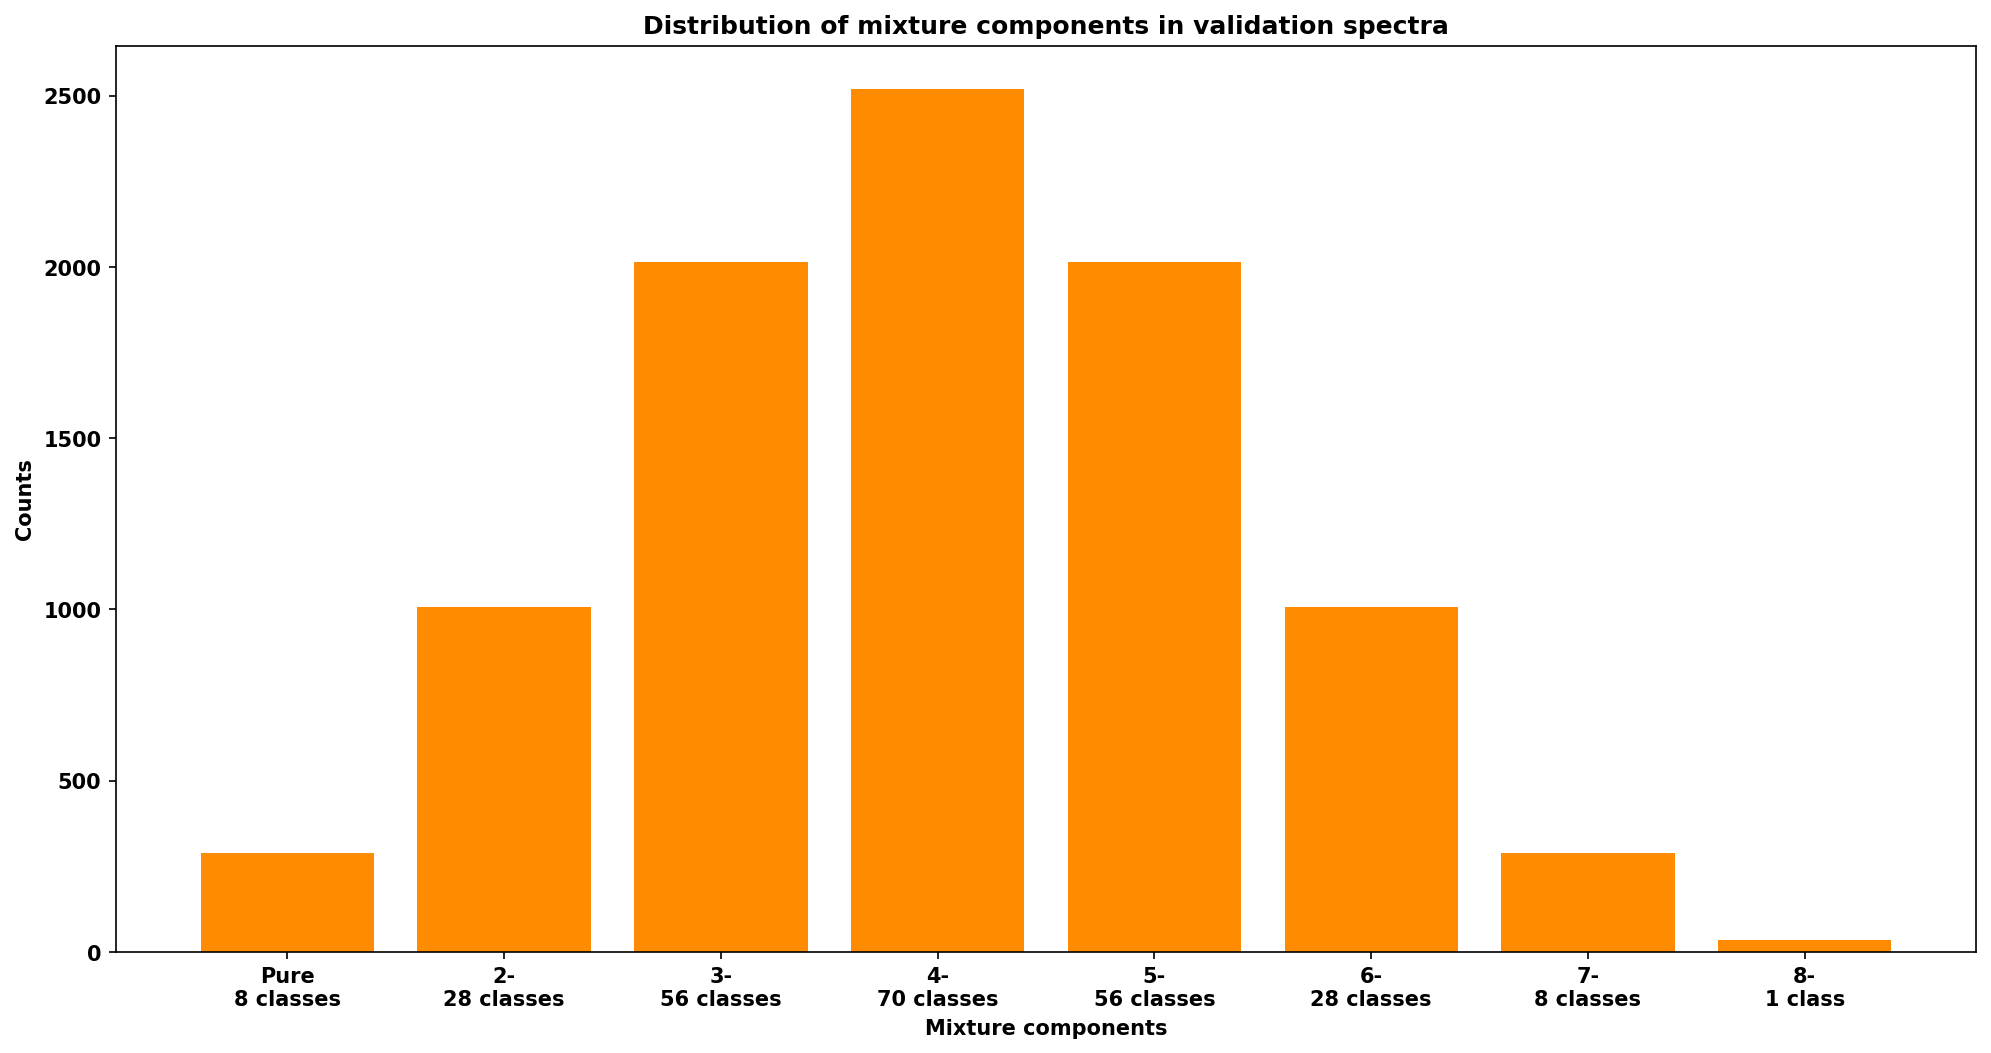

In [16]:
#calculate the distribution of 1,2,3,4,5,6,7,8 mixtures in train spectra

mix_1c = 0
mix_2c = 0
mix_3c = 0
mix_4c = 0
mix_5c = 0
mix_6c = 0
mix_7c = 0
mix_8c = 0

for _ in range(0,y_val_named.shape[0]):
    
        if len(y_val_named[_].split('+', -1)) == 1:
            mix_1c+=1
        elif len(y_val_named[_].split('+', -1)) == 2:
            mix_2c+=1
        elif len(y_val_named[_].split('+', -1)) == 3:
            mix_3c+=1
        elif len(y_val_named[_].split('+', -1)) == 4:
            mix_4c+=1
        elif len(y_val_named[_].split('+', -1)) == 5:
            mix_5c+=1
        elif len(y_val_named[_].split('+', -1)) == 6:
            mix_6c+=1
        elif len(y_val_named[_].split('+', -1)) == 7:
            mix_7c+=1
        elif len(y_val_named[_].split('+', -1)) == 8:
            mix_8c+=1
            
            
            
print('1-component mixtures:', mix_1c)
print('2-component mixtures:', mix_2c)
print('3-component mixtures:', mix_3c)
print('4-component mixtures:', mix_4c)
print('5-component mixtures:', mix_5c)
print('6-component mixtures:', mix_6c)
print('7-component mixtures:', mix_7c)
print('8-component mixtures:', mix_8c)

val_mix_1c =  mix_1c
val_mix_2c =  mix_2c
val_mix_3c =  mix_3c
val_mix_4c =  mix_4c
val_mix_5c =  mix_5c
val_mix_6c =  mix_6c
val_mix_7c =  mix_7c
val_mix_8c =  mix_8c


mix_dist_labels = ['Pure\n8 classes', '2-\n28 classes','3-\n56 classes','4-\n70 classes','5-\n56 classes','6-\n28 classes','7-\n8 classes','8-\n1 class']
mix_dists = [mix_1c,mix_2c,mix_3c,mix_4c,mix_5c,mix_6c,mix_7c,mix_8c]
plt.figure(figsize=(16,8),dpi=150)
plt.bar(mix_dist_labels, mix_dists, color='darkorange')
plt.xlabel('Mixture components', fontweight = 'bold')
plt.ylabel('Counts', fontweight = 'bold')
plt.title('Distribution of mixture components in validation spectra',  fontweight = 'bold')
plt.savefig(r'RESULTS/data_analytics/' + model_name +'_val_mix_dist.png', bbox_inches='tight')

In [17]:
mix_dist_labels = ['Pure\n8 classes', '2-\n28 classes','3-\n56 classes','4-\n70 classes','5-\n56 classes','6-\n28 classes','7-\n8 classes','8-\n1 class','Pure\n8 classes', '2-\n28 classes','3-\n56 classes','4-\n70 classes','5-\n56 classes','6-\n28 classes','7-\n8 classes','8-\n1 class']

mix_dists = [train_mix_1c,train_mix_2c,train_mix_3c,train_mix_4c,train_mix_5c,train_mix_6c,train_mix_7c,train_mix_8c,val_mix_1c,val_mix_2c,val_mix_3c,val_mix_4c,val_mix_5c,val_mix_6c,val_mix_7c,val_mix_8c]

set_labels = ['Train','Train','Train','Train','Train','Train','Train','Train','Validation','Validation','Validation','Validation','Validation','Validation','Validation','Validation']



df = pd.DataFrame()

df['mix_dist_labels'] = mix_dist_labels
df['mix_dists'] = mix_dists
df['set_labels'] = set_labels




In [50]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 16,9

In [23]:

# sns.set(rc={'figure.figsize':(9,9)})
# sns.set_style("whitegrid", {'axes.grid' : False})
# g = sns.catplot(
#     data=df, kind="bar",
#     x="mix_dist_labels", y="mix_dists", hue="set_labels",
#     palette="dark", alpha=1,height = 9)
# g.despine(left=False,right=True)
# g.set_axis_labels("Mixture components", "Counts")
# g.legend.set_title("")

/tmp/ipykernel_212884/1680371878.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),fontsize=15, fontweight='bold')


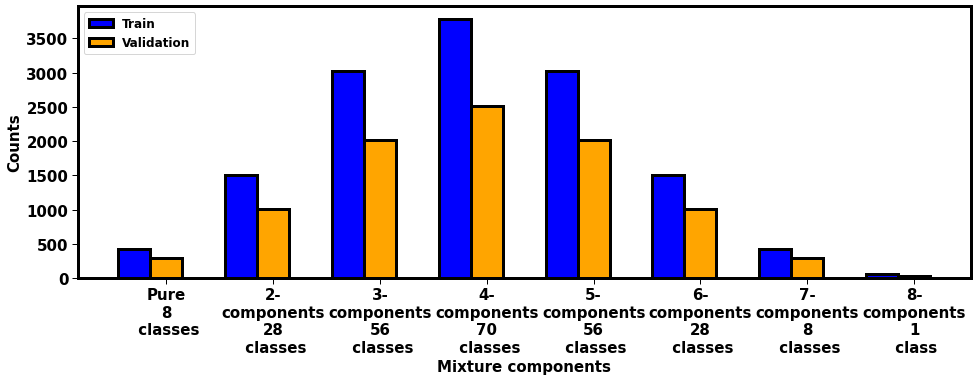

In [33]:
import matplotlib
from matplotlib.ticker import FormatStrFormatter

matplotlib.rc('font', family='sans-serif') 
# matplotlib.rc('font', serif='Helvetica Neue') 
# matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 22})

mix_dist_labels = ['Pure\n8\n classes', '2-\ncomponents\n28\n classes','3-\ncomponents\n56\n classes','4-\ncomponents\n70\n classes',
                   '5-\ncomponents\n56\n classes','6-\ncomponents\n28\n classes','7-\ncomponents\n8\n classes','8-\ncomponents\n1\n class']

train_mix_dists = [train_mix_1c,train_mix_2c,train_mix_3c,train_mix_4c,train_mix_5c,train_mix_6c,train_mix_7c,train_mix_8c]
val_mix_dists = [val_mix_1c,val_mix_2c,val_mix_3c,val_mix_4c,val_mix_5c,val_mix_6c,val_mix_7c,val_mix_8c]
train_set_labels = ['Train','Train','Train','Train','Train','Train','Train','Train']
val_set_labels = ['Validation','Validation','Validation','Validation','Validation','Validation','Validation','Validation']


fig, ax = plt.subplots()
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('3') 

fig.set_figheight(5)
fig.set_figwidth(16)

x = np.arange(len(mix_dist_labels))  # the label locations
width = 0.30 # the width of the bars

# fig = plt.figure(figsize=(1.6,1.6),dpi=300)
# ax_def = fig.add_axes([0, 0, 1, 1])
rects1 = ax.bar(x - width, train_mix_dists, width, label='Train', color='blue', edgecolor='black',linewidth=3)
# rects2 = ax.bar(x , val_mix_dists, width, label='Test', edgecolor='orange',linewidth=3)
rects3 = ax.bar(x, val_mix_dists, width, label='Validation', color='orange', edgecolor='black',linewidth=3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.legend(loc=2,prop={'size': 12})
ax.set_ylabel('Counts',fontsize=15, fontweight='bold')
ax.set_xlabel('Mixture components',fontsize=15, fontweight='bold')
# ax.set_title('Accuracy vs no. of features or variable'
#     .format(average_precision["micro"]),fontsize=18, fontweight='bold')

# ax.set_title('Same nine compounds\n classified in each group'
#     .format(average_precision["micro"]),fontsize=18, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(mix_dist_labels,fontsize=15, fontweight='bold')
ax.set_yticklabels(ax.get_yticks(),fontsize=15, fontweight='bold')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.xaxis.set_tick_params(which='major', size=6, width=1, direction='out',labelsize=15)
ax.xaxis.set_tick_params(which='minor', size=2, width=1, direction='out',labelsize=15)
ax.yaxis.set_tick_params(which='major', size=6, width=1, direction='out',labelsize=15)
ax.yaxis.set_tick_params(which='minor', size=6, width=1, direction='out',labelsize=15)
plt.savefig(r'RESULTS/data_analytics/' + model_name +'mix_dist.png', bbox_inches='tight')

notebook ends!